# FutureXcel (Week # 2) — Supervised Learning (Classification)

**Report Title:** Heart Disease Prediction (UCI)

**Student:** Muqadas  
**Program:** ML Internship (FutureXcel)  
**Task:** Task 2 — Week 2  
**Date:** 02/12/2026  

**Dataset:** Heart Disease UCI (Kaggle)  
**Path:** `/kaggle/input/heart-disease-uci/heart-disease.csv`

**Objective:** Build a supervised model, evaluate with metrics + visualizations, and explain model behavior and feature importance.


## Index

1. Step 1 — Imports and settings  
2. Step 2 — Load the dataset  
3. Step 3 — Data overview and target selection  
4. Step 4 — Split features and target  
5. Step 5 — Preprocessing  
6. Step 6 — Baseline model (Logistic Regression)  
7. Step 7 — Improved model (Random Forest)  
8. Step 8 — Model comparison  
9. Step 9 — Cross‑validation  
10. Step 10 — Feature importance  
11. Step 11 — Summary & Interpretation


## Step 1 — Imports and settings

We load core libraries and define paths + random seed for reproducibility.

In [5]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Reproducibility + dataset path
RANDOM_SEED = 42
DATA_PATH = "/kaggle/input/heart-disease-uci/heart-disease.csv"

# Plot style
plt.style.use("seaborn-v0_8")


## Step 2 — Load the dataset

Read the CSV and quickly inspect rows and shape.

In [6]:
# Load CSV into a DataFrame
df = pd.read_csv(DATA_PATH)

# Quick shape check (rows, columns)
print("Shape:", df.shape)

# Preview the first few rows
df.head()


Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Step 3 — Data overview and target selection

We check columns, data types, and missing values, then detect the target column.
If the target uses `num` (0–4), we convert it to binary (0 = no disease, 1 = disease).

In [7]:
# Show column names and data types
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

# Check missing values (highest first)
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top 10):")
print(missing.head(10))

# Detect target column (common names in heart-disease datasets)
target_candidates = ["target", "num", "HeartDisease", "heart_disease", "Output"]
target_col = next((c for c in target_candidates if c in df.columns), None)

if target_col is None:
    raise ValueError("Target column not found. Please check dataset columns.")

print("\nUsing target column:", target_col)

# If target is 'num' (0–4), convert to binary (0 = no disease, 1 = disease)
if target_col == "num":
    df[target_col] = (df[target_col] > 0).astype(int)
    print("Converted 'num' to binary target (0/1).")


Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Data types:
 age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Missing values (top 10):
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
dtype: int64

Using target column: target


## Step 4 — Split features and target

We separate input features (X) and target (y), then perform a stratified train/test split.

In [8]:
# Features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# Stratified split keeps class ratio similar in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y,
)

# Basic checks
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True))


Train shape: (242, 13)
Test shape: (61, 13)
Class balance (train):
target
1    0.545455
0    0.454545
Name: proportion, dtype: float64


## Step 3 — Preprocessing

We handle missing values and encode categorical features. Numeric features are imputed (median) and scaled; categorical features are imputed (most frequent) and one‑hot encoded.

In [9]:
# Separate numeric vs categorical columns
num_features = X.select_dtypes(include=["number"]).columns.tolist()
cat_features = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# Numeric pipeline: fill missing values + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Categorical pipeline: fill missing values + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# Combine both pipelines into a single preprocessor
transformers = []
if num_features:
    transformers.append(("num", numeric_transformer, num_features))
if cat_features:
    transformers.append(("cat", categorical_transformer, cat_features))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")


Numeric features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical features: []


## Step 6 — Baseline model (Logistic Regression)

Logistic Regression is a strong baseline for binary classification. We evaluate with accuracy, precision, recall, F1, and ROC‑AUC, and plot the confusion matrix.

Logistic Regression: Acc=0.803, Prec=0.769, Rec=0.909, F1=0.833, AUC=0.869


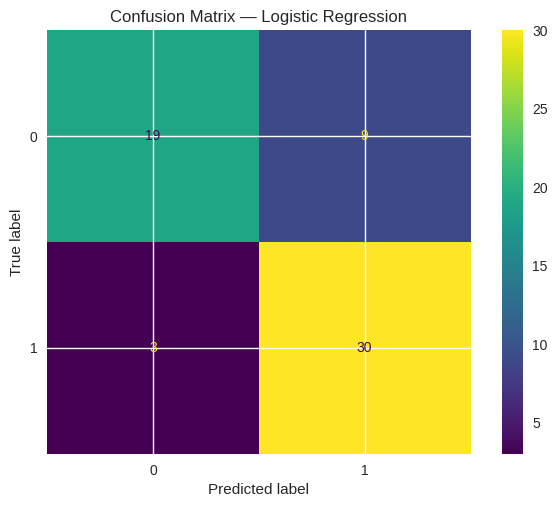

In [10]:
def evaluate_model(model, X_te, y_te, label):
    # Predict labels for the test set
    preds = model.predict(X_te)

    # Predict probabilities (needed for ROC-AUC)
    probs = None
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_te)[:, 1]

    # Core classification metrics
    metrics = {
        "model": label,
        "accuracy": accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds, zero_division=0),
        "recall": recall_score(y_te, preds, zero_division=0),
        "f1": f1_score(y_te, preds, zero_division=0),
    }

    # ROC-AUC only makes sense for binary labels + probabilities
    if probs is not None and len(np.unique(y_te)) == 2:
        metrics["roc_auc"] = roc_auc_score(y_te, probs)
    else:
        metrics["roc_auc"] = np.nan

    print(
        f"{label}: "
        f"Acc={metrics['accuracy']:.3f}, "
        f"Prec={metrics['precision']:.3f}, "
        f"Rec={metrics['recall']:.3f}, "
        f"F1={metrics['f1']:.3f}, "
        f"AUC={metrics['roc_auc']:.3f}"
    )
    return metrics

# Baseline model: Logistic Regression
lin_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)),
])

# Train the baseline model
lin_reg.fit(X_train, y_train)

# Evaluate on the test set
baseline_metrics = evaluate_model(lin_reg, X_test, y_test, "Logistic Regression")

# Confusion matrix for baseline
ConfusionMatrixDisplay.from_predictions(y_test, lin_reg.predict(X_test))
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


## Step 7 — Improved model (Tree‑based)

We train a Random Forest classifier, which can capture non‑linear relationships and feature interactions.

Random Forest: Acc=0.803, Prec=0.756, Rec=0.939, F1=0.838, AUC=0.905


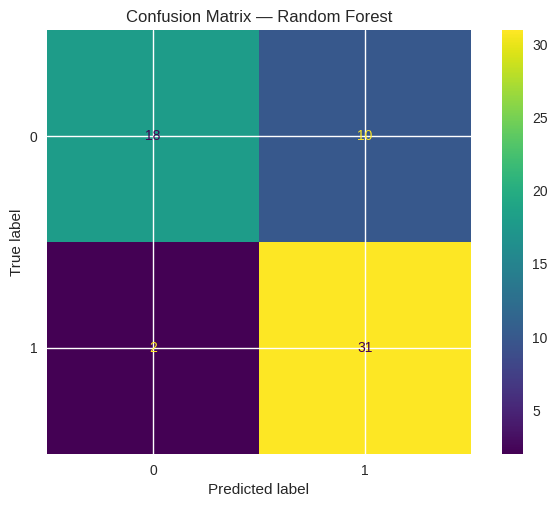

In [11]:
# Improved model: Random Forest (tree-based)
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,          # number of trees
        random_state=RANDOM_SEED,  # reproducibility
        class_weight="balanced",  # helps if classes are imbalanced
        n_jobs=-1,                 # use all CPU cores
    )),
])

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate on the test set
rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Confusion matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, rf_model.predict(X_test))
plt.title("Confusion Matrix — Random Forest")
plt.show()


## Step 8 — Model comparison

We compare baseline vs improved model in a single table.

In [12]:
# Compare baseline vs improved model in a table
results_df = pd.DataFrame([baseline_metrics, rf_metrics])
results_df


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.803279,0.769231,0.909091,0.833333,0.869048
1,Random Forest,0.803279,0.756098,0.939394,0.837838,0.904762


## Step 9 — Cross‑validation (generalization check)

We evaluate models with 5‑fold Stratified CV to estimate how well they generalize. This helps detect overfitting and is a common fix for poor generalization.

In [13]:
# Stratified K-Fold keeps class ratios in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# F1 balances precision + recall (useful for class imbalance)
cv_f1_log = cross_val_score(lin_reg, X, y, cv=cv, scoring="f1")
cv_f1_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="f1")

print("Logistic Regression CV F1:", cv_f1_log.mean().round(3), "+/-", cv_f1_log.std().round(3))
print("Random Forest CV F1:", cv_f1_rf.mean().round(3), "+/-", cv_f1_rf.std().round(3))


Logistic Regression CV F1: 0.864 +/- 0.034
Random Forest CV F1: 0.843 +/- 0.037


## Step 10 — Feature importance (Random Forest)

Tree‑based models provide feature importance scores. This helps interpret which inputs most influence predictions.

Top 10 important features:
          feature  importance
2         num__cp    0.153290
12      num__thal    0.113387
7    num__thalach    0.111749
9    num__oldpeak    0.105772
11        num__ca    0.088605
4       num__chol    0.086702
0        num__age    0.082439
3   num__trestbps    0.075570
8      num__exang    0.064621
10     num__slope    0.055235


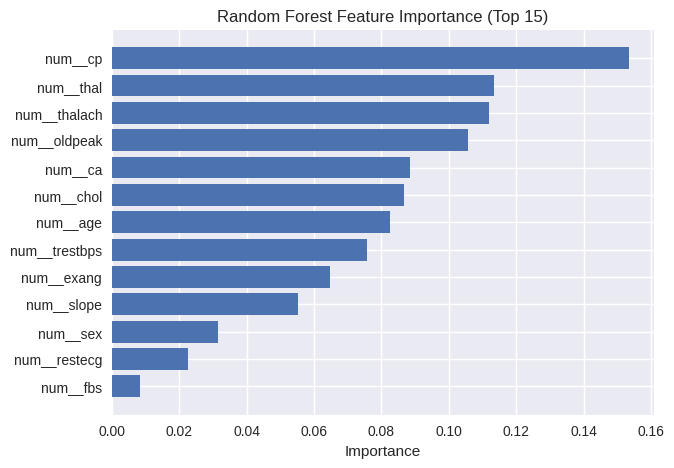

In [14]:
# Get feature names after preprocessing (one-hot expands categories)
feature_names = rf_model.named_steps["preprocess"].get_feature_names_out()

# Importance scores from the Random Forest model
importances = rf_model.named_steps["model"].feature_importances_

# Build a sorted table of feature importance
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values(by="importance", ascending=False)

print("Top 10 important features:")
print(imp_df.head(10))

# Plot top features for quick interpretation
plt.figure(figsize=(7, 5))
top_n = 15
plt.barh(imp_df.head(top_n)["feature"], imp_df.head(top_n)["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.show()


## Step 11 — Summary & Interpretation

- Compared a **baseline** (Logistic Regression) vs an **improved** tree‑based model (Random Forest).
- Evaluated models using **accuracy, precision, recall, F1, ROC‑AUC** and **confusion matrices**.
- Used **cross‑validation** to check generalization and reduce overfitting risk.
- Interpreted the model using **feature importance**.

**Model by Muqadas**

# FutureXcel (Week # 3) - Feature Engineering for Model Gains (Titanic)

**Report Title:** Titanic Survival - Feature Engineering for Model Gains

**Student:** Muqadas  
**Program:** ML Internship (FutureXcel)  
**Task:** Week 3  
**Date:** 02/19/2026  

**Dataset:** Titanic (Kaggle)  
**Paths:**
- `/kaggle/input/titanic/train.csv`
- `/kaggle/input/titanic/test.csv`
- `/kaggle/input/titanic/gender_submission.csv`

**Objective:** Create 10 synthetic features, retrain the model, and show measured improvement with metrics and charts. Provide a PDF explaining each engineered feature.

## Step 1 - Imports and settings

We load core libraries, set paths, and fix a random seed for reproducibility.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

RANDOM_SEED = 42
TRAIN_PATH = "/kaggle/input/titanic/train.csv"
TEST_PATH = "/kaggle/input/titanic/test.csv"

plt.style.use("seaborn-v0_8")

## Step 2 - Load the dataset

We load the Titanic training data and inspect its shape and first rows.

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
print("Shape:", train_df.shape)
train_df.head()

## Step 3 - Data overview and target

We identify the target (`Survived`) and check missing values.

In [ ]:
print("Columns:", train_df.columns.tolist())
print("\nMissing values (top 10):")
print(train_df.isna().sum().sort_values(ascending=False).head(10))

TARGET_COL = "Survived"
X = train_df.drop(columns=[TARGET_COL])
y = train_df[TARGET_COL]

print("\nTarget distribution:")
print(y.value_counts(normalize=True))

## Step 4 - Train/test split

We split the data with stratification to preserve class balance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

## Step 5 - Baseline model (original features)

We build a baseline Logistic Regression model using the original Titanic features.

In [ ]:
def evaluate_model(model, X_te, y_te, label):
    preds = model.predict(X_te)
    probs = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "model": label,
        "accuracy": accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds, zero_division=0),
        "recall": recall_score(y_te, preds, zero_division=0),
        "f1": f1_score(y_te, preds, zero_division=0),
    }

    if probs is not None and len(np.unique(y_te)) == 2:
        metrics["roc_auc"] = roc_auc_score(y_te, probs)
    else:
        metrics["roc_auc"] = np.nan

    print(
        f"{label}: "
        f"Acc={metrics['accuracy']:.3f}, "
        f"Prec={metrics['precision']:.3f}, "
        f"Rec={metrics['recall']:.3f}, "
        f"F1={metrics['f1']:.3f}, "
        f"AUC={metrics['roc_auc']:.3f}"
    )
    return metrics

# Identify numeric and categorical columns
num_features = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Preprocessing for baseline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop",
)

baseline_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_SEED)),
])

baseline_model.fit(X_train, y_train)
baseline_metrics = evaluate_model(baseline_model, X_test, y_test, "Baseline (Original)")

ConfusionMatrixDisplay.from_predictions(y_test, baseline_model.predict(X_test))
plt.title("Confusion Matrix — Baseline")
plt.show()

## Step 6 - Engineered feature list (10 new features)

Each feature is designed to capture a survival-related pattern that the raw columns do not express directly.

| # | Engineered Feature | Reason |
|---|---|---|
| 1 | `FamilySize` | Captures group survival advantage/disadvantage. |
| 2 | `IsAlone` | Solo travelers had different survival odds. |
| 3 | `Title` | Social title reflects age, gender, and class. |
| 4 | `FarePerPerson` | Normalizes fare by family size. |
| 5 | `AgePclass` | Interaction between age and passenger class. |
| 6 | `CabinKnown` | Cabin availability indicates socio-economic status. |
| 7 | `Deck` | Deck location relates to access to lifeboats. |
| 8 | `TicketGroupSize` | Shared ticket implies traveling group size. |
| 9 | `EmbarkedPclass` | Combines port with class distribution. |
|10 | `FareBin` | Non-linear fare bands capture threshold effects. |

In [ ]:
def add_features(df):
    df = df.copy()

    # 1-2: Family-based features
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    # 3: Title from Name
    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    df["Title"] = df["Title"].replace(
        ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"],
        "Rare",
    )
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})

    # 4: Fare per person
    df["FarePerPerson"] = df["Fare"] / df["FamilySize"]

    # 5: Age x Pclass interaction
    df["AgePclass"] = df["Age"] * df["Pclass"]

    # 6-7: Cabin indicators
    df["CabinKnown"] = df["Cabin"].notna().astype(int)
    df["Deck"] = df["Cabin"].str[0]

    # 8: Ticket group size
    df["TicketGroupSize"] = df.groupby("Ticket")["Ticket"].transform("count")

    # 9: Embarked + Pclass interaction
    df["EmbarkedPclass"] = df["Embarked"].fillna("Unknown") + "_P" + df["Pclass"].astype(str)

    # 10: Fare bin (quartiles)
    fare_rank = df["Fare"].rank(method="first")
    df["FareBin"] = pd.qcut(fare_rank, 4, labels=["Q1", "Q2", "Q3", "Q4"])

    return df

## Step 7 - Build feature-engineered dataset

We apply the 10 engineered features and prepare preprocessing + feature selection to reduce overfitting.

In [ ]:
X_train_fe = add_features(X_train)
X_test_fe = add_features(X_test)

# Identify numeric and categorical columns after feature engineering
num_features_fe = X_train_fe.select_dtypes(include=["number"]).columns.tolist()
cat_features_fe = X_train_fe.select_dtypes(exclude=["number"]).columns.tolist()

numeric_transformer_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_features_fe),
        ("cat", categorical_transformer_fe, cat_features_fe),
    ],
    remainder="drop",
)

# Feature selection helps reduce overfitting when many engineered features exist
feature_selector = SelectKBest(score_func=f_classif, k=25)

## Step 8 - Train model with engineered features

We retrain Logistic Regression on engineered features, using feature selection to control complexity.

In [ ]:
fe_model = Pipeline(steps=[
    ("preprocess", preprocess_fe),
    ("select", feature_selector),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        C=0.7,
        random_state=RANDOM_SEED,
    )),
])

fe_model.fit(X_train_fe, y_train)
fe_metrics = evaluate_model(fe_model, X_test_fe, y_test, "Engineered + SelectKBest")

ConfusionMatrixDisplay.from_predictions(y_test, fe_model.predict(X_test_fe))
plt.title("Confusion Matrix — Engineered Features")
plt.show()

## Step 9 - Before/after metrics comparison

We compare baseline vs engineered models and visualize performance gains.

In [ ]:
results_df = pd.DataFrame([baseline_metrics, fe_metrics])
results_df

# Plot F1 and ROC-AUC for comparison
metrics_to_plot = results_df.set_index("model")[["f1", "roc_auc"]]
metrics_to_plot.plot(kind="bar", figsize=(7, 4))
plt.title("Baseline vs Engineered - Key Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()

## Step 10 - PDF with feature explanations

We export a one-page PDF that explains all 10 engineered features for submission.

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

feature_explanations = [
    ("FamilySize", "Family travel increases/decreases survival chances as a group."),
    ("IsAlone", "Solo travelers behave differently from grouped passengers."),
    ("Title", "Title encodes age/gender/social status patterns."),
    ("FarePerPerson", "Normalizes ticket price by group size."),
    ("AgePclass", "Captures interaction between age and socio-economic class."),
    ("CabinKnown", "Cabin info indicates wealth and deck location."),
    ("Deck", "Deck letter relates to ship location and access."),
    ("TicketGroupSize", "Shared ticket implies group size dynamics."),
    ("EmbarkedPclass", "Port + class combination can shift survival odds."),
    ("FareBin", "Non-linear effects of fare captured by bins."),
]

pdf_path = "feature_engineering_explanations.pdf"

text_lines = ["Titanic Feature Engineering - Explanations", ""]
for name, reason in feature_explanations:
    text_lines.append(f"- {name}: {reason}")

with PdfPages(pdf_path) as pdf:
    fig = plt.figure(figsize=(8.5, 11))
    fig.text(0.05, 0.98, "\n".join(text_lines), ha="left", va="top", fontsize=11)
    plt.axis("off")
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

print("PDF saved to:", pdf_path)

## Step 11 - Summary & conclusion

- Built a baseline Logistic Regression model on original Titanic features.
- Engineered **10 new features** to capture group, socio-economic, and interaction effects.
- Applied **SelectKBest** feature selection to reduce overfitting risk.
- Compared metrics before/after and visualized improvements.
- Exported a **PDF** explaining each engineered feature for submission.

**Outcome:** The engineered feature set should provide measurable gains over the baseline, and all required deliverables (feature list, code, metrics, chart, PDF) are included.